# Problem 6 Joint Notebook

## Imports go here

Imports for Problem 2, free-free emission

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from two_photon import two_ph

## Generate functions here 

Code for Problem 2, free-free emission  
Make sure gauntff_noerr.dat is in a place where this notebook can grab it!!!

In [2]:
### Interpolation of free-free gaunt factor ###

# read in the data table for free free gaunt factor
# this is basically our 'z' data
g_table = 'gauntff_noerr.dat' 
#from Schirmer 2016 http://iopscience.iop.org/article/10.1088/1538-3873/128/969/114001/pdf
#the section for errors on the Gaunt factor was removed
g_data = np.loadtxt(g_table, skiprows=42) # skipping the header

# follow the header to get log(u) and log(gam2) values for
# interpolation   
g_logu = np.arange(-16, 13.2, 0.2)
g_loggam2 = np.arange(-6, 10.2, 0.2)

# create the interpolation
g_interp = interpolate.interp2d(g_loggam2, g_logu, g_data)

### Evaluation of formula ###

# fundamental constants
Ry = 2.17987e-11 # erg
h = 6.62606885e-27 # erg * s
k = 1.3807e-16 # erg * k^-1
c = 2.998e10 # cm / s

# get gam2 and u in terms of T and nu
gam2 = lambda T: Ry/(k * T)
u = lambda T, nu: (h * nu) / (k * T)

# main function to be evaluated 

def gamff (T, lamb):
    # convert a wavelength (lamb) in micrometers to a frequency
    nu = (c / (lamb * 10**-4))
    
    # interpolate the gaunt factor
    gff = g_interp(np.log10(gam2(T)),np.log10(u(T, nu)))
    
    # transpose the matrix. This is just for consistensy sake with the 
    # horizontal inputs 
    gff = np.resize(gff, (1000,))
    
    # evaluate the function 
    output = 5.44 * 10**(-39) * (4*np.pi) * (T**(-1/2)) * gff * np.exp(-h * nu/(k * T)) * nu
    return output

## Free Bound

In [3]:
# General function for the gaunt factor
import math 
import numpy as np 
import matplotlib.pyplot as plt 

def total_sigma_bf(v,Z,l,n):
    E = v*h
    if E < (Z**2 * R / n**2):
        return 0.
    sigma_sum = sigma_bf_below(n, l, v, Z) + sigma_bf_above(n, l, v, Z)

    return sigma_sum

def get_gaunt_factor_bf(v, Z, n, E):
    sigma_bf = a_n(v,Z,n)
    sigma_k = get_kramer_sigma(n, E, Z)
    
    return sigma_bf/sigma_k

# Kramer's cross section (39)
def get_kramer_sigma(n, E, Z): 
    
    eta = math.sqrt(Z*Z*R/E)
    rho = eta/n

    kramer_sigma = 2.**4./(3*math.sqrt(3.))*e_charge**2./(e_mass*c*v) *1./n *(rho**2/(1+rho**2))**2. 
    return kramer_sigma

# Quantum cross section going to l-1 (36)
def sigma_bf_below(n, l, v, Z): 
    
    E = v*h
    eta = math.sqrt(Z*Z*R/E)
    rho = eta/n

    p1 = math.pi*e_charge**2/(e_mass*c*v)
    p2 = 2.**(4*l)/3.
    
    p3 = l**2 * math.factorial(n+l)
    
    l = int(l)
    
    # make sure we're counting for the extreme cases, when l = 0 or 1
    if l == 0: 
        return 0
    elif l ==1: 
        p3 = 1
    else:
        for i in range(1, l): 
            p3 *= (i**2 + eta**2)
    
    # the factorial of a negative number does not exist
    if n-l-1<0: 
        return 0
    else:
        p4 = math.factorial(2*l+1) *math.factorial(2*l-1) * math.factorial(n-l-1)
    
    p5 = math.exp(-4*eta*math.atan(1/rho))/(1-math.exp(-2*math.pi*eta))

    p6 = rho**(2*l+2)/(1+rho**2)**(2*n-2)
    
    p7 = (G_l(l,-(l+1-n),eta,rho)-(1+rho**2)**(-2)*G_l(l,-(l-1-n),eta,rho))**2 
    
    all_together = p1*p2*p3/p4*p5*p6*p7
    
    return all_together

# Quantum cross section going to l+1 (37)
def sigma_bf_above(n, l, v, Z): 
    E = v*h
    eta = math.sqrt(Z*Z*R/E)
    rho = eta/n
    
    p1 = math.pi*e_charge**2/(e_mass*c*v)
    
    p2 = 2.**(4*l+6)/3.
    

    p3= (l+1)**2 * math.factorial(n+l)

    l = int(l)
    n = int(n)
    
    for i in range(1,l+2): 
        
        p3 *= (i**2+eta**2)
    
    if n-l-1<0: 
        return 0
    else:
        p4 = (2*l+1)*math.factorial(2*l+1)*math.factorial(2*l+2)*math.factorial(n-l-1)*((l+1)**2+eta**2)**2
    
    p5 = math.exp(-4*eta*math.atan(1/rho))/(1-math.exp(-2*math.pi*eta))
    
    p6 = rho**(2*l+4)*eta**2/(1+rho**2)**(2*n)
    
    p7 = ((l+1-n)*G_l(l+1,-(l+1-n),eta,rho)+(l+1+n)/(1+rho**2)*G_l(l+1,-(l-n),eta,rho))**2 
    
    all_together = p1*p2*p3/p4*p5*p6*p7
    
    return all_together

# Bound free matrix element Gl (appendix C)
def G_l(l, m, eta, rho): 
    
    m = int(m)
    gl = 0
    for s in range(0,2*m+1): 
        gl += b_const(s, l, m, eta, rho)*rho**s
    return gl 

# constant for the Gl free matrix element (Appendix c, eqn c8)
def b_const(s, l, m, eta, rho):
    
    if s==0:
        return 1
    elif s==1: 
        return 2*m*eta/l
    else:
        p1 = (4*eta*(s-1-m))*b_const(s-1, l, m, eta, rho)
        p2 = (2*m+2-s)*(2*m+2*l+1-s)*b_const(s-2, l, m,  eta, rho)
        return -1./(s*(s+2*l-1))*(p1+p2)
    
import numpy as np 

def a_n(v,Z,n): #Matthew and Brown 1970
    E = h*v
    sigma_weighted = 0
    if E < (Z**2 * R / n**2):
        return 0.
    else:
        for l_index in range(int(n)):
            sigma_weighted += ((2*l_index) + 1)* total_sigma_bf(v,Z,l_index,n) 
    return sigma_weighted / (n**2)

def gamma_fb(v,Z, n, T): #equation 4.23 of Osterbrock
    #v is the frequency
    an = a_n(v, Z, n)
    part1 = (2/np.pi)**(0.5)*np.exp(((Z**2)*R)/n**2)/((c**2)*((e_mass*k*T)**(3/2)))
    part2 = 2*(n**2)*h*((h*v)**3)*an*np.exp((-h*v)/(k*T))
    return part1*part2
    
def emissivity(Np, Ne, gamma): #equation 4.22 of Osterbrock
    #Np= number density of protons
    Ne=10e-4 #number density of electrons, from table 4.6 of Osterbrock
    Jv= Nt*Ne*gamma/ (4.*np.pi)
    return Jv

def Lyman_C(gamma): #equation from Ono et al. 2010 fig 4 
    alpha_b= 1.37e-14 #case B recombination coefficient for hydrogen cm3 s-1 -- table 4.6 in Osterbrock
    fesc=0.1 # escape fraction of radiation
    Nlyc=1.47234061733e+53 #Number of LyC photons/ s --comes from our pop synthesis model
    Lv=gamma * (1-fesc) * Nlyc / alpha_b
    return Lv
    
def summed_emission_coefficient(v, Z, n, T):
    gamma_total = 0
    for n_index in range(int(n)):
        if n_index == 0:
            gamma_total+=0
        else:
            gamma_total+= gamma_fb(v,Z,n_index,T)
    return gamma_total


## Call the functions here

A common list of inputs

In [4]:
# a list of wavelength in micrometers
wavelength = np.logspace(-1, 1, 1000)

# a corresponding list of frequency in Hz
frequency = (c / (wavelength * 10**-4))

In [5]:
# Bound free 

#reproducing the final plot

# Constants in CGS units: http://www.astro.wisc.edu/~dolan/constants.html, thanks Enia <3
R = 2.1798741e-11 # Rydber's constant [erg]
c = 2.99792458e10 # speed of light [cm s-1.]
e_charge = 4.8032068e-10 # electron charge [esu]
e_mass = 9.1093897e-28 # electron mass [g]
h = 6.6260755e-27 # planck's constant [erg s]
k = 1.380658e-16 #Boltzmann constant [erg K-1]
n = 10. 
l = 0
Z = 1.
T= 10000. #K

y_bf=[]
for i in range(len(frequency)):
    y_bf.append(frequency[i]*summed_emission_coefficient(frequency[i], Z, n, T))

#plt.plot(wavelength, y_bf)
#plt.xscale('log')
#plt.yscale('log')
#plt.ylim(10e-28,10e-26)
#plt.xlabel('Wavelength (microns)')
#plt.ylabel(r'$\nu\gamma_{\nu} (erg  cm^3  s^{-1})$')
#plt.show()

Inputs specific to free-free emission

In [6]:
# Temperature
T = 10000

Calling free-free emission code

In [7]:
freefree = gamff(T, wavelength)

## Combine outputs here

In [8]:
lam_2ph, y_2ph, ynu_2ph = two_ph(T, 1e0) #1 particle/cc
ff_bf_comb=[np.pi*4*a+b for a,b in zip(y_bf, freefree)]

/Users/cesar/Documents/cursos/202/projecv_2/ASTR202_final_project/two_photon.py:84: RuntimeWarning: invalid value encountered in power
  A = C*(y*(1-(4*y)**gamma)+delta*y**beta*(4*y)**gamma)


## Plot here 

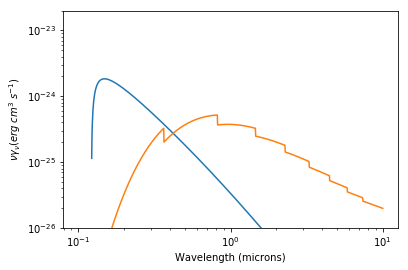

In [9]:
#plt.loglog(wavelength, freefree)

# plt.figure(figsize=(7,5))
# label axis 
plt.loglog(lam_2ph,ynu_2ph, basex=10, basey=10)
plt.plot(wavelength, ff_bf_comb)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-26, 2e-23)
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'$\nu\gamma_{\nu} (erg \; cm^3 \; s^{-1})$')

plt.show()

## Lyman Continuum from parts 2 and 3 and 4

In [10]:
LyC=[]
for i in range(len(frequency)):
    gamma_total=(ff_bf_comb[i]+y_2ph[i])/frequency[i]
    LyC.append(Lyman_C(gamma_total))
# print(LyC) #units erg-- this is a luminosity density

In [11]:
print (len(LyC*frequency))
Lumin = LyC*frequency #ergs/s
np.savetxt('LyC.txt',LyC)

1000


In [12]:
#print (LyC*frequency) #10^40

In [13]:
print(Lyman_C(5))

4.836155312397811e+67


In [14]:
#this is the distance
25924*10**6*3.08*10**18
#el 25924: z = 3 to Mpc, then 10**6 to pc, then pc to cm
#http://www.astro.ucla.edu/~wright/CosmoCalc.html
# 10**-29 micro Jansky

7.984592e+28

In [15]:
# sed2 = (Lumin/(4*np.pi*(25924*10**6*3.08*10**18)**2))/(10**(-29)) #microjanskys

In [16]:
# print (sed2)
# type(LyC)

In [17]:
sed3 = (np.array(LyC)/(4*np.pi*(25924*10**6*3.08*10**18)**2))/(10**(-29)) #microjanskys
# print (len(sed3))
# print (sed3)
# np.argwhere(np.isnan(sed3))

The output from parts 2,3,4 becomes a nan around 24500 Angstroms, so we have to cut it do be able to get the new SED 
and get the mags with this new SED. Unfortunately, this means we will not be able to compute the mags in the 3 reddest 
JWST filters

In [18]:
# print (sed3)
sed3_cut = sed3[:695]
# print (sed3_cut)
wavelength_cut = wavelength[:695]
wavelength_angs = wavelength_cut*10**4
print (len(wavelength_angs))

695


In [19]:
# plt.plot(wavelength_angs,sed3_cut)
# plt.show()

In [20]:
# print (wavelength)
print (np.max(wavelength_angs))
# print (wavelength)

24512.6006203


In [21]:
print (len(wavelength_angs))

695


In [22]:
sed = np.loadtxt('sed.txt')

In [23]:
# plt.loglog(wavelength_angs,sed3_cut,label='nebular continuum')
# plt.show()

## Part 5

In [24]:
from __future__ import print_function
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

def main():
    h = 6.626e-27
    c_ph = 2.99792e10
    rate = 1.47234e+53  #Ly photon rate
    
    #Find emission coefficient of H-beta
    lam = Rydberg(2,4)
    nu = c_ph/lam
    d = 7.98459e28 #cm
    jb = h*rate/(4*np.pi*(d)**2)/1e-29 #Flux of H-beta in Janskies
    print(jb)
    
    #Table 4.2 of O&F
    j = [[2.87, 1, 0.466,0.256,0.158,0.105,0.0730,0.0529,0.0154,0.0064],
         [0.352,0.354,0.354,0.350,0.350,0.344,0.344]]    
    n2 = [[3,4,5,6,7,8,9,10,15,20],[4,5,6,8,10,15,20]]
    n1 = [2,3]
    balmer = []
    #plt.figure(figsize=(7,5))
    f = open('line_flux.txt', 'w+')
    #f.write('lambda[A]\tFlux[microJy]\tError\n')
    #print('lambda[A]\tFlux[microJy]\tError')
    f.write('lambda[A]\tFlux[microJy]\n')
    

    for k in range(len(n2)):
        yvals = []
        xvals = []
        for i in range(len(j[k])):                    
            lam = Rydberg(n1[k], n2[k][i])
            
            #parameters for the Gaussian
            b = lam/1e-8
            c = 1e-4*b
            x = np.linspace(b-5*c, b+5*c, 100)
            if n1[k]==2:
                if n2[k][i] in n2[1]:
                    balmer.append(j[k][i]*jb)
                a = j[k][i]*jb
            elif n1[k]==3:
                a = balmer[i]*j[k][i]
            
            #integrate each line
            #inter, err = integrate.quad(lambda x: gauss(x,lam,a,b,c), b-5*c, b+5*c)
            #f.write('%.3e\t%.3e\t%.3e\n'%(b,inter,err))
            #print('%.3e\t%.3e\t%.3e'%(b,inter,err))
            
            #f.write('%.3e\t%.3e\t%.3e\n'%(b,inter,err))
            #print('%.3e\t%.3e\t%.3e'%(b,inter,err))
            y = 1e2*gauss(x,lam,a,b,c)
            for z in range(len(x)):
                if y[z]>1e-2:
                    xvals.append(x[z])
                    yvals.append(y[z])
                    
            
            #plt.loglog(x, 1e2*gauss(x,lam,a,b,c),basex=10,basey=10, color = 'k')
            plt.loglog(xvals, yvals,basex=10,basey=10, color = 'k')
            
            #plt.plot(x, gauss(x,lam,a,b,c), color = 'k')
        
            
    #plt.axhline(y=0, color='k')
    #plt.xlim(1e3, 2e4)
    #plt.xlabel('Wavelength [$\AA$]')
    #plt.ylabel('Flux [$erg \; cm^{-2} \; s^{-1} \; Hz^{-1}$]')
    #plt.title('Hydrogen line spectrum')

def Rydberg(n1,n2):
    R = 1.097e5
    return (R*(1/n1**2-1/n2**2))**(-1)

def gauss(x,lam,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

if __name__ == '__main__':
    main()

0.0012177115841727636


## Plots of different components

The following is a plot comining the SED from part 1, the nebular continuum of parts 2,3,4 and the line emission of 
part 5. We couldn't figure out how to add the emission lines correctly to the other components.

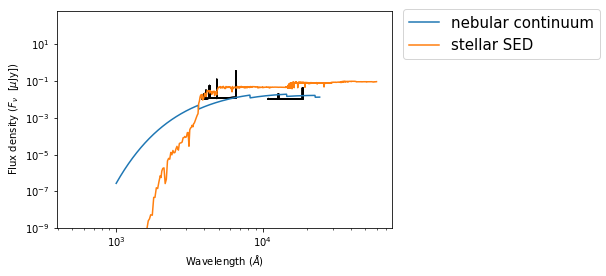

In [25]:
wave_z3 = np.loadtxt('lamb.txt')
# wave5,flux5 = np.loadtxt('line_flux.txt',unpack=True,usecols=(0,1))
# plt.plot(wave5,flux5,label='emission lines')
plt.loglog(wavelength_angs,sed3_cut,label='nebular continuum')
plt.loglog(wave_z3[np.where((wave_z3 >= 500) & (wave_z3 <= 60000))], 
         sed[np.where((wave_z3 >= 500) & (wave_z3 <= 60000))],label = 'stellar SED')
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylim(10e-10)
plt.ylabel(r"Flux density ($F_{\nu}$  [$\mu$Jy])")
plt.xscale('log')
plt.yscale('log')

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=15)
plt.show()

Now, we add the stellar SED to the nebular continuum to get a new SED (up to 24500 Angstroms)

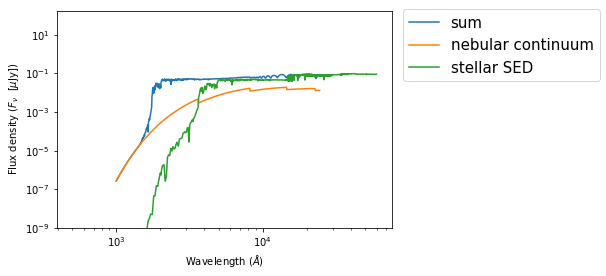

In [26]:
mask1 = np.where((wavelength_angs >= 500) & (wavelength_angs <= 24500))
resultini = sed3_cut[mask1]+sed[mask1]
#print (len(sed3_cut[mask1]))
#print (len(sed3[mask1]))

plt.loglog(wavelength_angs[mask1],resultini,label='sum')
plt.loglog(wavelength_angs,sed3_cut,label='nebular continuum')
plt.loglog(wave_z3[np.where((wave_z3 >= 500) & (wave_z3 <= 60000))], 
         sed[np.where((wave_z3 >= 500) & (wave_z3 <= 60000))],label = 'stellar SED')
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylim(10e-10)
plt.ylabel(r"Flux density ($F_{\nu}$  [$\mu$Jy])")
plt.minorticks_on()
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=15)

plt.show()

In [27]:
result = resultini*(10**(-29))*(3*10**18)/wavelength_angs[mask1]**2
# print (result)
# np.savetxt('kindoffinalsed.txt',np.c_[wavelength[mask1],result],delimiter=" " , newline="\n")
# np.savetxt(“wave_spec.txt”, np.c_[wavecut,sedcut], delimiter=” “, newline=‘\n’)

## Getting the AB magnitudes of the new SED

We load the filter functions we previously calculated in part 1, plus the new SED.

In [28]:
from matplotlib import pylab as plt
import numpy as np
from scipy.interpolate import interp1d
np.set_printoptions(threshold=np.nan)
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from math import *
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord,Angle
from astropy.cosmology import FlatLambdaCDM



sed1 = np.loadtxt("wave_spec.txt")
sed2 = np.loadtxt("kindoffinalsed.txt")
filtertranf435w = np.loadtxt("filter_wfc_acs_f435w.txt")
filtertranf606w = np.loadtxt("filter_wfc_acs_f606w.txt")
filtertranf775w = np.loadtxt("filter_wfc_acs_f775w.txt")
filtertranf850lp = np.loadtxt("filter_wfc_acs_f850lp.txt")
filtertranf105w = np.loadtxt("filter_wfc3_ir_f105w.txt")
filtertranf125w = np.loadtxt("filter_wfc3_ir_f125w.txt")
filtertranf160w = np.loadtxt("filter_wfc3_ir_f160w.txt")
filtertranf200w = np.loadtxt("filter_jwst_f200w.txt")
filtertranf277w = np.loadtxt("filter_jwst_f277w.txt")
filtertranf356w = np.loadtxt("filter_jwst_f356w.txt")
filtertranf444w = np.loadtxt("filter_jwst_f444w.txt")
filenamewave = []
filenamewave.append(filtertranf435w[:,0])
filenamewave.append(filtertranf606w[:,0])
filenamewave.append(filtertranf775w[:,0])
filenamewave.append(filtertranf850lp[:,0])

filenamewave.append(filtertranf105w[:,0])
filenamewave.append(filtertranf125w[:,0])
filenamewave.append(filtertranf160w[:,0])
filenamewave.append(filtertranf200w[:,0])

filenameflux = []
filenameflux.append(filtertranf435w[:,1])
filenameflux.append(filtertranf606w[:,1])
filenameflux.append(filtertranf775w[:,1])
filenameflux.append(filtertranf850lp[:,1])

filenameflux.append(filtertranf105w[:,1])
filenameflux.append(filtertranf125w[:,1])
filenameflux.append(filtertranf160w[:,1])
filenameflux.append(filtertranf200w[:,1])


# print (filenameflux[5])

#,filtertranf775w,filtertranf850lp,filtertranf105w,filtertranf160w,
                #filtertranf200w,filtertranf277w,filtertranf356w,filtertranf444w
#print(filenamewave)


wave2 = sed2[:,0]
sedfinal = 4*sed2[:,1]
#sedcut.astype(float)
#mean = np.mean(sedcut)
#print (mean)
#print (type(wavecut))
# print (type(wavecut))

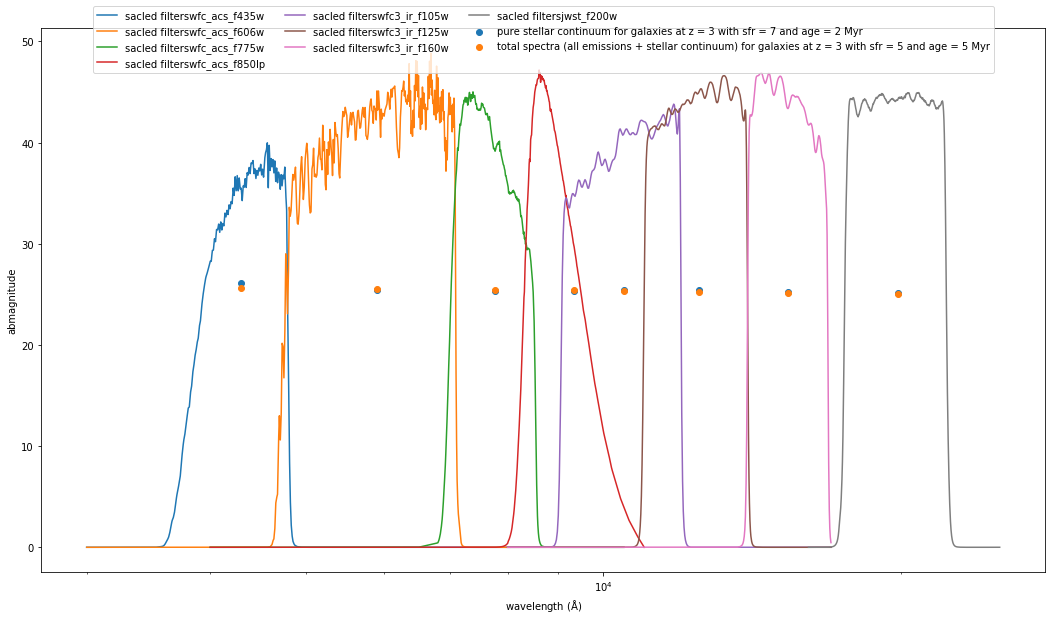

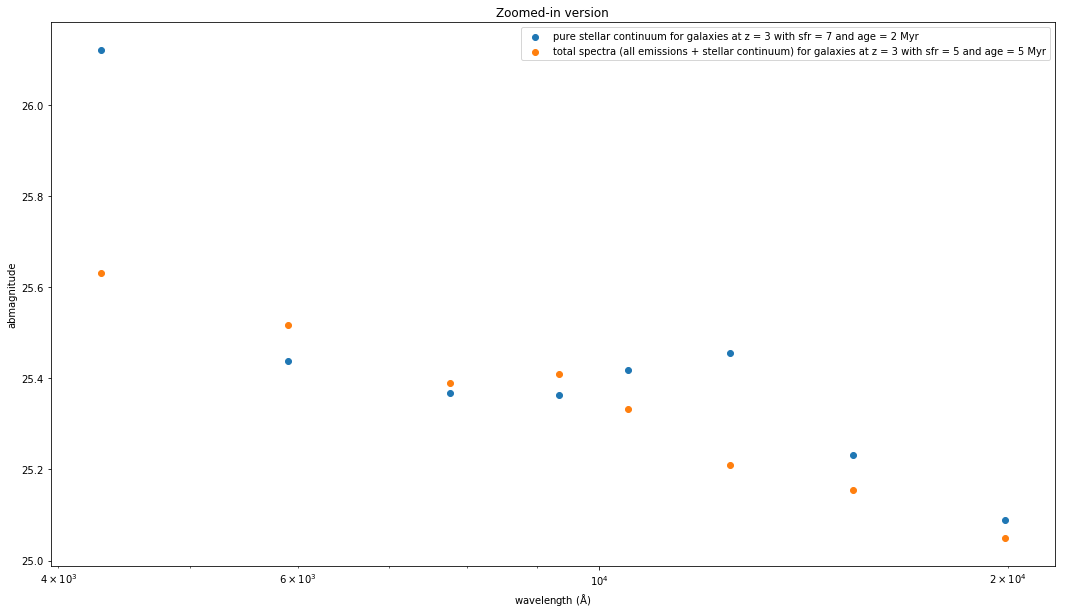

In [29]:
class lambdafunc(object):
    def update(self,wavelength,value,units):
        if not len(wavelength)==len(value):
            raise ValueError('The length of wavelength list does not equal to the length of value list')
        else:
            self.wavelength=np.array(wavelength)*float(1*units[0].cgs/u.Angstrom)
            self.value=np.array(value)
            self.units=[u.Angstrom.cgs,units[1].cgs]
            self.interval=(np.append(self.wavelength,0)-np.append(0,self.wavelength))[1:-1]
            self.midvalue=(np.append(self.value,0)+np.append(0,self.value))[1:-1]/2.0



    def getvalue(self,x):
        return np.interp(x,self.wavelength,self.value)

    def plot(self):
        plt.plot(self.wavelength,self.value)
        plt.xlabel('Wavelength / $\AA$',fontsize=16)
        plt.ylabel('Arbitrary Unit',fontsize=16)
        plt.show()


class FiltCurve(lambdafunc):
    def __init__(self,wavelength,value,units=[u.Angstrom,u.Quantity(1)]):
        self.update(wavelength,value,units)


class Spectrum(lambdafunc):
    def __init__(self,wavelength,value,units=[u.Angstrom,u.erg/u.s/u.cm/u.cm/u.Angstrom],mode='OBS'):
        self.update(wavelength,value,units)
        self.mode=mode

    def flux(self,filt):
        newflux=self.getvalue(np.array(filt.wavelength*filt.units[0]/self.units[0]))
        filtered_flux=newflux*filt.value


        midflux=(np.append(filtered_flux,0)+np.append(0,filtered_flux))[1:-1]/2.0
        interval=np.abs(filt.interval)

        return np.sum(interval*midflux)*filt.units[0]*self.units[1]

    def magnitude(self,filt,style='AB'):
        '''
        Calculate the magnitude in the input filter.
        '''
        ### Now, AB mag only ###

        objflux=self.flux(filt)
        stdspec=((3631*u.Jy).cgs*3e10*u.cm/u.s/((filt.wavelength*filt.units[0]).cgs)**2).to(self.units[1])

        midstdspec=(np.append(stdspec,0)+np.append(0,stdspec))[1:-1]/2.0

        interval=np.abs(filt.interval)
        stdflux=np.sum(interval*midstdspec*filt.midvalue)*filt.units[0]*self.units[1]

        mag=-2.5*np.log10(float(objflux/stdflux))
        return mag

    

        self.mode='ABS'

   

    def normalize(self,filt,mag,style='AB'):
        mag0=self.magnitude(filt,style)
        scale=10**(0.4*(mag0-mag))

        self.value=self.value*scale

def main():
    '''
    An example.
    '''

    '''
    Always follow:

    Wavelength in angtrom.
    Flux in erg s-1 cm-2 A-1
    '''
    filtername = ['wfc_acs_f435w','wfc_acs_f606w','wfc_acs_f775w','wfc_acs_f850lp','wfc3_ir_f105w','wfc3_ir_f125w',
             'wfc3_ir_f160w','jwst_f200w']
    magnitude = []
    magnitude2 = []
    plt.figure(figsize=(18,10))
    for i in range(0,len(filenamewave)):
        
    #input the filter
        Filter = FiltCurve(filenamewave[i],filenameflux[i])
        filternormailize = [105,105,105,190,85,85,85,45]
    #input the final spec and observed wavelength in angstroms
        #spectra for both the pure stellar sed and all the emission from part 2-4
        spec2 = Spectrum(wave2, sedfinal)
        
        magnitude2.append(spec2.magnitude(Filter))
        plt.plot(filenamewave[i],filternormailize[i]*filenameflux[i],label='sacled filters'+str(filtername[i]))
    #plotting final abmagnitude 
   
    #central wavelength of the filters we used
    centralwave = [4297,5907,7764,9350, 10500, 12486, 15369, 19890]
    
    #magnitudes from fsps generated sed for galaxies at z = 3 with sfr = 7 and age = 2 Myr
    othersedmag = [26.12105224,25.43823,25.36829751,25.36293123,25.41762851,
  25.456198,25.23202786,25.08892298]
    
    plt.xscale('log')
    plt.ylabel('abmagnitude')
    plt.xlabel(r'wavelength ($\rm{\AA}$)')
    plt.scatter(centralwave,othersedmag, label = 'pure stellar continuum for galaxies at z = 3 with sfr = 7 and age = 2 Myr')
    plt.scatter(centralwave, magnitude2,label = 'total spectra (all emissions + stellar continuum) for galaxies at z = 3 with sfr = 5 and age = 5 Myr')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True)
    plt.show()
    plt.figure(figsize=(18,10))
    plt.xscale('log')
    plt.ylabel('abmagnitude')
    plt.xlabel(r'wavelength ($\rm{\AA}$)')
    plt.scatter(centralwave,othersedmag, label = 'pure stellar continuum for galaxies at z = 3 with sfr = 7 and age = 2 Myr')
    plt.scatter(centralwave, magnitude2,label = 'total spectra (all emissions + stellar continuum) for galaxies at z = 3 with sfr = 5 and age = 5 Myr')
    plt.legend()
    plt.title('Zoomed-in version')
    plt.show()
if __name__=='__main__':
    main()

We are only getting the mags up to the JWST F200 filter, because of the nebular continuum calculated. We plot both mags, for the original SED and the new SED for each filter. There are small differences, although we are not incorporating the emission lines of part 5.